## Problem Statement

As the world gains access to internet, forum moderators faced difficulty in handling large amount of spams or misclassified post. 

In this project, we aim to perform research,building and implementation of a NLP classifier model. The model which we have created is a binary classification model. This will be a proof-of-concept for the management of online forums. Upon successful POC, this project could be further taken into a scalable project for multi-class classification with sound budget.

## Executive Summary

As the world becomes more developed, human beings have realised the importance of overall well being both mentally and physically. Understanding text through Natural Language Processing techniques of two subreddit Mental Health and Fitness gives us a good basis of text classfication. 

Data is parsed and gathered from these two popular reddit posts. Subsequently, these data are splitted into training and test data for modelling and evaluation using machine learning techniques.

In this project, we have used mainly the two classifer: 

- Naive Bayes Classifier
- Logisitc Regression

After modelling of the two classifier, Naive Bayes Mutlinomial Classifier performed the best in terms of accuracy score. Misclassification rate for this model is relatively low and it appears to be the presence of some weighted words of other post appearing on the other. 

In order to increase the performance of the model, further research on contextualising would needed to be performed. This would help to identify more important feature.

## Process

1. Data Gathering (JSon/PushShiftAPI)
2. Data Cleaning and Pre-processing
3. EDA
4. Baseline Accuracy
5. Modelling
6. Model Evaluation
7. Limitation and Recommendation
8. Conclusion

## Data Cleaning & Pre-processing


### Importing libraries required

In [1]:
#Import the libraries
import numpy as np
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib
import stylecloud



import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Reddit post for both topics were parsed using Json and downloaded into csv file in previous script. In this script, we have imported into csv and process the text for our study.

In [2]:
#import csv for fitness reddit post
df_f= pd.read_csv('../data/fitness.csv')

In [3]:
#import csv for mental health reddit post

df_mh= pd.read_csv('../data/mentalhealth.csv')

Since title and selftext contains mainly text which are useful for our text classficaition, I have narrowed to these columns for investigation.

In [4]:
#selected columns which contains mostly text which is useful for our text classification 
cols = ['title', 'selftext','subreddit']
df_mh=df_mh[cols]
df_f=df_f[cols]

In [5]:
#check shape
print(df_f.shape)
print(df_mh.shape)

(995, 3)
(996, 3)


## Data Cleaning
- Check for null dataset
- Check for duplicate posts
- Combining columns (selftext and title)


### Fitness Reddit Data Cleaning

In [6]:
#check for null in dataframe
df_f.isnull().sum()

title        0
selftext     0
subreddit    0
dtype: int64

Sine there are no null in fitness thread, we will proceed on.

In [7]:
#combining title and selftext for text processing
df_f['title_selftext']= df_f['title']+ ' '+df_f['selftext']

In [8]:
# 180 observations are duplicated
df_f['title_selftext'].duplicated().value_counts()


False    815
True     180
Name: title_selftext, dtype: int64

Dropping duplicates rows since the number of thread of duplicated thread is insignificant

In [9]:
#dropping duplicates
df_f.drop_duplicates(inplace=True,subset='title_selftext')


In [10]:
df_f.shape

(815, 4)

### Mental Health Reddit Data Cleaning

To make text processing meaningful, i have concat the two variable for analysis.

In [11]:
#combining  title and selftext for text processing 
df_mh['title_selftext']= df_mh['title']+ ' '+df_mh['selftext']


In [12]:
#21 rows of na in selftext
df_mh.isnull().sum()

title              0
selftext          21
subreddit          0
title_selftext    21
dtype: int64

In [13]:
#drop the 21 rows of null since the ratio is small
df_mh.dropna(inplace=True)

In [14]:
df_mh.shape

(975, 4)

In [15]:
#there are no duplicates
df_mh['title_selftext'].duplicated().value_counts()

False    975
Name: title_selftext, dtype: int64

In [16]:
# set classifying label for r/fitness as 0, mentalhealth as 1.

df_mh['label']=1
df_f['label']=0

In [17]:
# appending both reddit post into one dataframe
combined = df_mh.append(df_f)

In [18]:
#resetting index 
combined.reset_index(inplace=True,drop=True)


In [19]:
#check the shape make sure the observations are correct
combined.shape

(1790, 5)

In [20]:
combined.head()

,title,selftext,subreddit,title_selftext,label
0,Anyone else feel as though they have been depr...,The feeling or urge you get when you sit there...,mentalhealth,Anyone else feel as though they have been depr...,1
1,Both of my parents have died in a car accident...,I'm gonna make this post quick. And simple. Bo...,mentalhealth,Both of my parents have died in a car accident...,1
2,Does anyone get anxious because of time being ...,"It's been like this for the past few weeks, i ...",mentalhealth,Does anyone get anxious because of time being ...,1
3,"if anyone has mental health questions,","i’m not a professional, sorry. but I recently ...",mentalhealth,"if anyone has mental health questions, i’m not...",1
4,Does anyone have time to talk?,I got married last week. My bride is sleeping ...,mentalhealth,Does anyone have time to talk? I got married l...,1


In [21]:
#re-ordering the dataframe
combined= combined[['subreddit','label','title_selftext']]

In [22]:
# customize stopwords list, will update into the default stopword
mystopwords=['mental health','mental','health','fitness','reddit','https','http','com','www','ve']

In [23]:
#write a function to convert a long form reddit post to a string of words
def cleanreview(raw_post,mystopwords):
    
    # 1. Remove HTML.
    post_text = BeautifulSoup(raw_post).get_text()
    
    # 2. Remove non-letter, remove some html tags that people use on reddit to get extra "breaks" in the post, 
    #removing the sub reddit tags
    letters_only = re.sub("[www.reddit.com]{14}|[&#x200B;]{8}|[&nbsp;]{6}|[^A-z]|\[|\]", " ", post_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
        
    # 4. Set is more efficient in searching
    # a list, so convert the stop words to a set.
    stops = set(stop_words.ENGLISH_STOP_WORDS)
    stops.update(mystopwords)
    
    # 5. Remove stop words.
    meaningful_words = [w for w in words if not w in stops]
    
    # 6. Lemmatize the words.
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    
    # 7. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(lemma_words))

In [24]:
# Converted to  words, then append to clean_post.
cleaned_posts = []
for post in combined['title_selftext']:
    cleaned_posts.append(cleanreview(post,mystopwords))



In [25]:
cleaned_titleselftext = pd.DataFrame(cleaned_posts, columns=['cleaned_selftext'])

In [26]:
# combining the cleaned selftext with original DF  
combined = combined.join(cleaned_titleselftext, how='left')
print(len(combined))
combined.head()

1790


,subreddit,label,title_selftext,cleaned_selftext
0,mentalhealth,1,Anyone else feel as though they have been depr...,feel deprived affection physical emotional fee...
1,mentalhealth,1,Both of my parents have died in a car accident...,parent died car accident early december m gonn...
2,mentalhealth,1,Does anyone get anxious because of time being ...,doe anxious time limited s like past week gett...
3,mentalhealth,1,"if anyone has mental health questions, i’m not...",question m professional sorry recently psychia...
4,mentalhealth,1,Does anyone have time to talk? I got married l...,doe time talk got married week bride sleeping ...


In [27]:
# saving this dataframe
combined.to_csv('../data/combined.csv')

## Dataframe Pre-processing

**Train/Test split of dataframe**
- 1 train data
- 1 test data


In [28]:
X = combined['cleaned_selftext']
y = combined['label']

In [29]:
# using the train data to perform train & test set
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,random_state=22 )

In [30]:
#exporting for save
X_test.to_csv('../data/X_test.csv')
y_test.to_csv('../data/y_test.csv')

In [31]:
X_train.shape

(1342,)

In [32]:
X_test.shape

(448,)

## EDA 
### Generating wordcloud


We will be using visual aids to identify if there is any distinct or overlapping word using train data. This will allow us to understand misclassification of our selected model in the later part of our project.

In [33]:
stop=set(stop_words.ENGLISH_STOP_WORDS)

In [34]:
stop.update(mystopwords)

In [35]:
new_train = pd.concat([X_train, y_train], axis=1)

In [36]:
# performing subsetting of post for mental health
df_mh=new_train[new_train['label'] == 1]

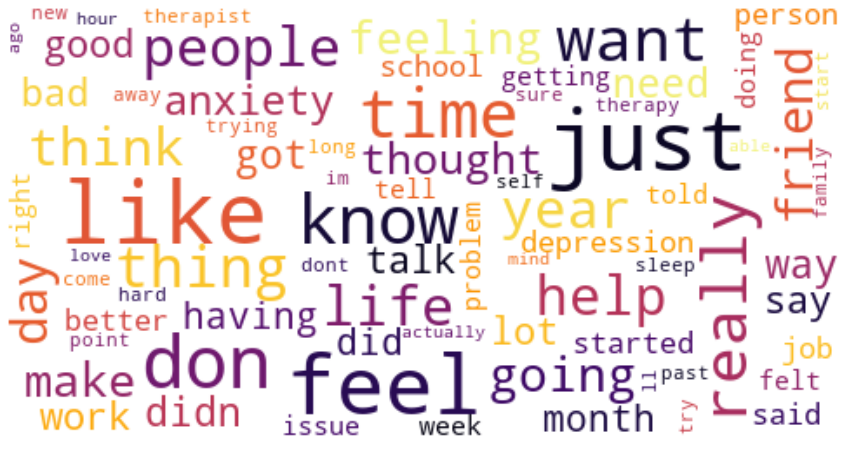

In [37]:
# to plot a 50 word wordcloud for r/mentalhealth
## https://stackoverflow.com/questions/43954114/python-wordcloud-repetitve-words
## to remove duplicate word, set collocations to false
wordcloud = WordCloud(collocations=False,width=480, height=250,max_font_size=50, max_words=75, background_color="white",
                      stopwords=stop,colormap=matplotlib.cm.inferno,).generate(' '.join(df_mh['cleaned_selftext']))

plt.figure(figsize=[15,8])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('../image/mh.png');

In [38]:
# performing subsetting of post for fitness

df_f = new_train[new_train['label'] == 0]

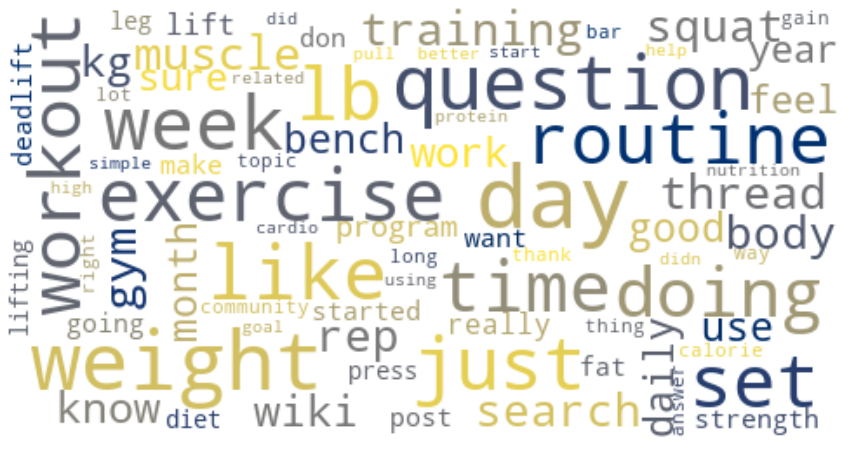

In [39]:
# to plot a 50 word wordcloud for r/fitness

wordcloud = WordCloud(collocations=False,width=480, height=250,max_font_size=50, max_words=75, 
                      background_color="white",stopwords=stop,colormap=matplotlib.cm.cividis).generate(' '.join(df_f['cleaned_selftext']))

plt.figure(figsize=[15,8])
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")
plt.show()
wordcloud.to_file('../image/fit.png');

A wordcloud may be useful to identify top words, but it lack of frequecncy of its occurence. 

##  Bonus:Using stylecloud library to create cool wordcloud for presentation use

In [40]:
#installing stylecloud library
#!pip install stylecloud 
import stylecloud


In [41]:
mentalhealth_text=' '.join(df_mh['cleaned_selftext'])
fitness_text=' '.join(df_f['cleaned_selftext'])


In [42]:
join_text= mentalhealth_text+' '+fitness_text

In [43]:
#style cloud to output a reddit image for join text
stylecloud.gen_stylecloud(collocations=False,text=join_text,icon_name='fab fa-reddit-alien',
                          output_name='../image/reddit.png',stopwords=stop)

![alt text](../image/reddit.png)


In [44]:
# stylecloud to use a dumbbell image
stylecloud.gen_stylecloud(background_color='lightgrey',collocations=False,text=fitness_text,icon_name='fas fa-dumbbell',
                          output_name='../image/fitness.png',stopwords=stop)

![alt text](../image/fitness.png)

In [45]:
#style cloud using running man image
stylecloud.gen_stylecloud(background_color='lightgrey',collocations=False,text=mentalhealth_text,icon_name='fas fa-running',
                          output_name='../image/mentalhealth.png',stopwords=stop)

![alt text](../image/mentalhealth.png)

### Plotting with Countvectorizer & TFID Vectorizer

In [46]:
#Instantiate  CountVectorizer object
gcvec = CountVectorizer(stop_words=stop)
gtvec = TfidfVectorizer(stop_words=stop)

**Mental Health**

In [47]:
mh_list = [stories for stories in df_mh['cleaned_selftext']]


In [48]:
list_mh_gcvec = pd.DataFrame(gcvec.fit_transform(mh_list).todense(),
                            columns=gcvec.get_feature_names())

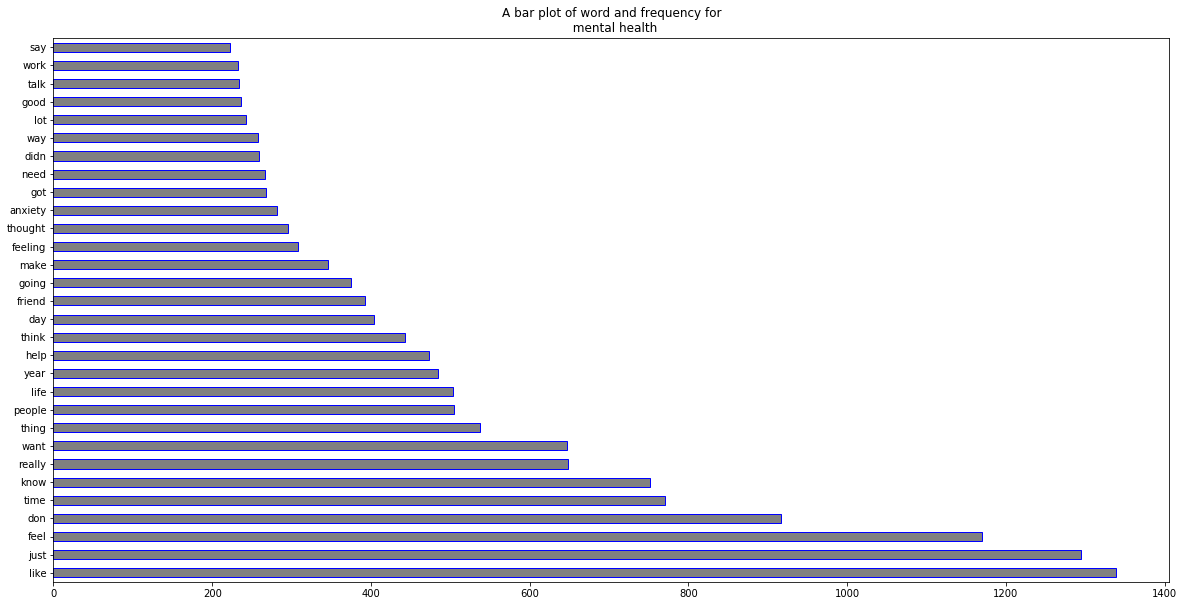

In [49]:
list_mh_gcvec.sum().sort_values(ascending=False).head(30).plot(
    kind='barh',title='A bar plot of word and frequency for\n  mental health',figsize=(20,10),
    color='grey',edgecolor='blue');


In [50]:
# Fit the vectorizer on our documents of mental health.
list_mental_gtvec = pd.DataFrame(gtvec.fit_transform(mh_list).todense(),
                            columns=gtvec.get_feature_names())


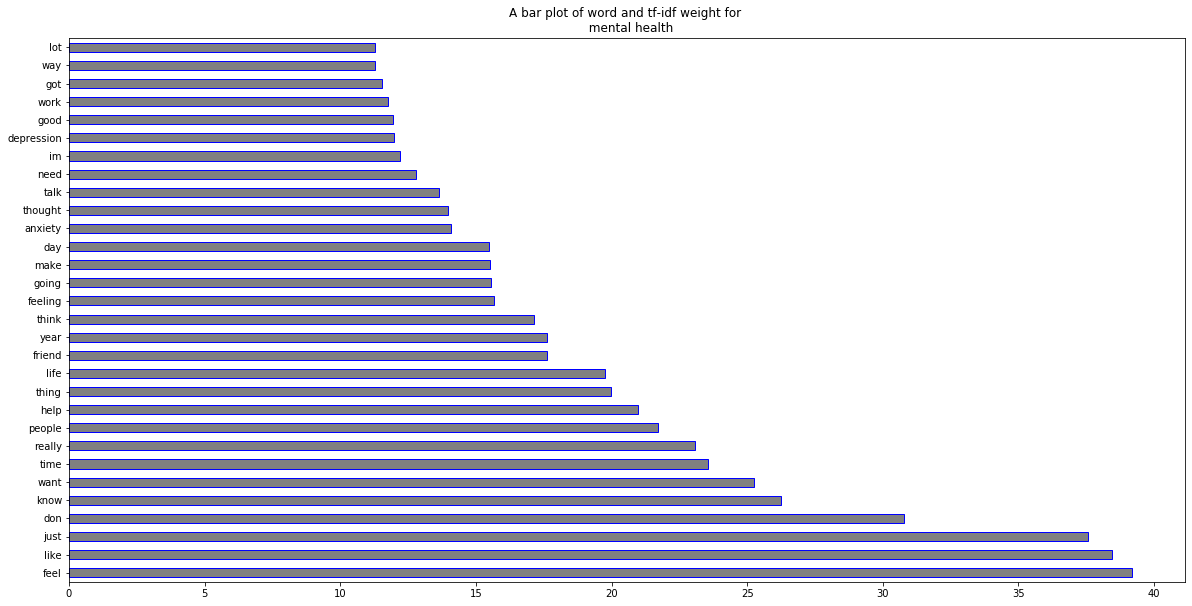

In [51]:
list_mental_gtvec.sum().sort_values(ascending=False).head(30).plot(
    kind='barh',title='A bar plot of word and tf-idf weight for \n  mental health',figsize=(20,10),
    color='grey',edgecolor='blue');

It was observed that there are different word appearing in countvectrozier and Tfidfvectorizer like 'Depression'. This could be due to weightage given in TFidFvectorizer.

**Fitness**

In [52]:
#Fit the vectorizer on our documents of nosleep.
f_list = [stories for stories in df_f['cleaned_selftext']]


In [53]:
list_f_gcvec = pd.DataFrame(gcvec.fit_transform(f_list).todense(),
                            columns=gcvec.get_feature_names())

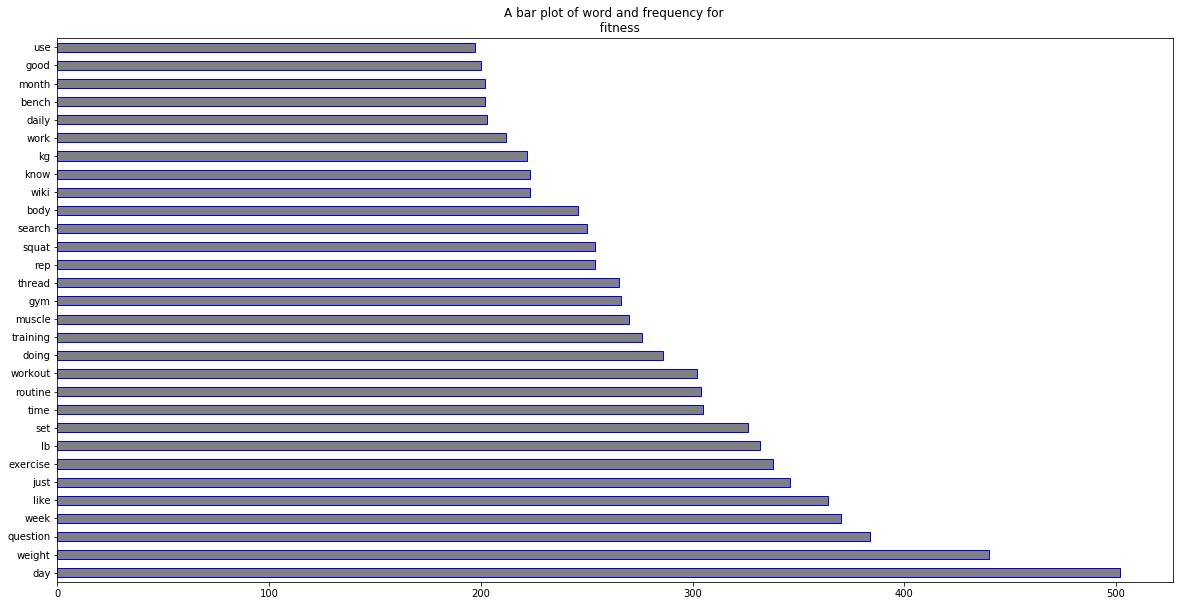

In [54]:
list_f_gcvec.sum().sort_values(ascending=False).head(30).plot(
    kind='barh',title='A bar plot of word and frequency for \n  fitness',figsize=(20,10),
    color='grey',edgecolor='blue');

In [55]:
# Fit the vectorizer on our documents of fitness.
list_fitness_gtvec = pd.DataFrame(gtvec.fit_transform(f_list).todense(),
                            columns=gtvec.get_feature_names())



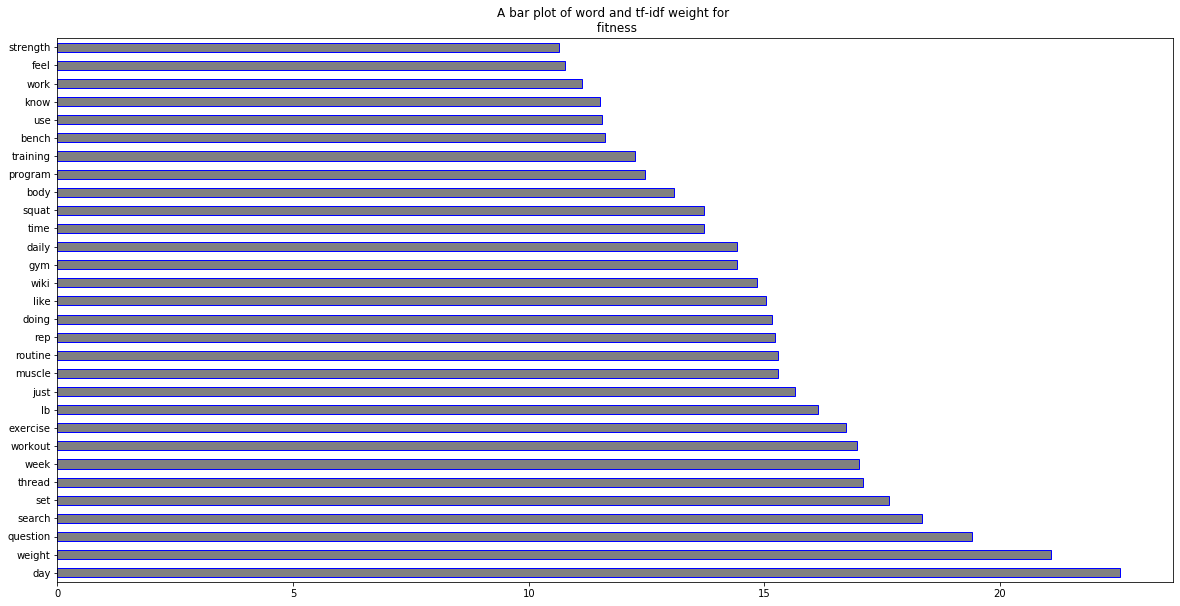

In [56]:
list_fitness_gtvec.sum().sort_values(ascending=False).head(30).plot(
    kind='barh',title='A bar plot of word and tf-idf weight for \n fitness',figsize=(20,10),
    color='grey',edgecolor='blue');


It was observed that there are different word appearning in countvectrozier and Tfidfvectorizer like 'feel'. It was also observed that 'feel' was present in the both thread post as the top 30 words.

## Baseline Accuracy

In [57]:
#baseline accuracy is  approx 54%

combined['subreddit'].value_counts(normalize=True)


mentalhealth    0.544693
Fitness         0.455307
Name: subreddit, dtype: float64

## Model
### Create Pipeline

We will create respective pipelines for comparison. First we will use gridsearch to identify optimal paramters, following which we will then model with the optimal parameters. Lastly, we will test the model with test set.
<br> </br>
<br>**Naive Bayes**</br>
<p>
1. CountVectorizer
<br>2. TfidfVectorzier
    <p>
    <b>Logistic Regression</b>
<br>3. CountVectorizer</br>
<br>4. TfidfVectorzier</br></p>

**1) Naive Bayes with CountVectorizer method**

**a) Using Gridsearch to identify optimal parameters**

In [58]:
pipe_cvnb = Pipeline([
    ('cvec', CountVectorizer(stop_words=stop)),
   ('nb', MultinomialNB())
])

In [59]:

pipe_params_c1 = {
    'cvec__max_features': [1000,3500, 5000],
    'cvec__min_df': [1, 3, 5],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [60]:
gs_best1 = GridSearchCV(pipe_cvnb, param_grid=pipe_params_c1, cv=5)
gs_best1.fit(X_train, y_train)
print(gs_best1.best_score_)
gs_best1.best_params_

0.9910581222056631


{'cvec__max_df': 0.9,
 'cvec__max_features': 3500,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1)}

**Key parameters**
- 0.988822652757079
- 'cvec__max_df': 0.9,
-  'cvec__max_features': 3500,
- 'cvec__min_df': 1,
- 'cvec__ngram_range': (1, 1)

**b) Modelling with tuned parameters**

In [61]:
naive_c_pipe= Pipeline([
    ('cvec',CountVectorizer(stop_words=stop ,max_df=0.9
                            ,max_features=3500,min_df=1,ngram_range=(1,1)))
, ('nb',MultinomialNB())
])

In [62]:
naive_c_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.9,
                                 max_features=3500, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words={'a', 'about', 'above', 'across',
                                             'after', 'afterwards', 'again',
                                             'against', 'all', 'almost',
                                             'alone', 'along', 'already',
                                             'also', 'although', 'always', 'am',
                                             'among', 'amongst', 'amoungst',
                                             'amount', 'an', 'and', 'another',
  

In [63]:
print('Train score: ', round(naive_c_pipe.score(X_train, y_train),4))

Train score:  0.9963


In [64]:
print('Train score: ', round(naive_c_pipe.score(X_test, y_test),4))

Train score:  0.9844


In [65]:
predict1=naive_c_pipe.predict(X_test)

In [66]:
# confusion matrix function

def metric(y_test, predictions):
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    print('--------Metrics--------')
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp)
    


In [67]:
metric(y_test,predict1)

--------Metrics--------
True Negatives: 198
False Positives: 6
False Negatives: 1
True Positives: 243


#### **2) Naive Bayes with TfidfVectorizer method**

**a)Using gridsearch to identify optimal parameters**

In [68]:
pipe_tf = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stop)),
    ('nb', MultinomialNB())
])

In [69]:
pipe_params_tf = {
    'tvec__max_features': [1000,3500, 5000],
    'tvec__min_df': [1, 3, 5],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [70]:
gs_best3 = GridSearchCV(pipe_tf, param_grid=pipe_params_tf, cv=5)
gs_best3.fit(X_train, y_train)
print(gs_best3.best_score_)
gs_best3.best_params_

0.9895678092399404


{'tvec__max_df': 0.9,
 'tvec__max_features': 3500,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 1)}

**Key parameter**
- 0.9850968703427719
- 'tvec__max_df': 0.9,
- 'tvec__max_features': 3500,
- 'tvec__min_df': 3,
- 'tvec__ngram_range': (1, 1)

**b) Modelling with optimal parameters**

In [71]:
naive_t_pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stop,max_df=0.9,max_features=3500,min_df=3,ngram_range=(1,1))),
    ('nb', MultinomialNB())
])

In [72]:
naive_t_pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.9, max_features=3500,
                                 min_df=3, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words={'a', 'about', 'above', 'across',
                                             'after', 'afterwards', 'again',...
                                             'alone', 'along', 'already',
                                             'also', 'although', 'always', 'am',
                                             'among', 'amongst', 'amoungst',
                                             'amount', 'an', 'and', 'another',
         

In [73]:
print('Train score: ',round(naive_t_pipe.score(X_train, y_train),4))

Train score:  0.9963


In [74]:
print('Train score: ',round(naive_t_pipe.score(X_test,y_test),4))

Train score:  0.9821


In [75]:
predict2 = naive_t_pipe.predict(X_test)

In [76]:
metric(y_test, predict2)

--------Metrics--------
True Negatives: 197
False Positives: 7
False Negatives: 1
True Positives: 243


**3) Logistric Regression with Countvectorizer method**

**a) Using Gridsearch to identify optimal parameters**

In [77]:
pipe_cvlr = Pipeline([
    ('cvec', CountVectorizer(stop_words=stop)),
    ('lr', LogisticRegression(solver='lbfgs'))
])

In [78]:
gs_best2 = GridSearchCV(pipe_cvlr, param_grid=pipe_params_c1, cv=5)
gs_best2.fit(X_train, y_train)
print(gs_best2.best_score_)
gs_best2.best_params_

0.981371087928465


{'cvec__max_df': 0.9,
 'cvec__max_features': 1000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1)}

**Key parameter**
- 0.9791356184798807
- 'cvec__max_df': 0.9,
- 'cvec__max_features': 3500,
- 'cvec__min_df': 3,
- 'cvec__ngram_range': (1, 1)

**b) Model with optimal  parameters**

In [79]:
c_l_pipe=Pipeline([
    ('cvec',CountVectorizer(stop_words=stop,max_df=0.9,max_features=3500,min_df=3,ngram_range=(1,1))),
    ('lr',LogisticRegression(solver='lbfgs'))

])

In [80]:
c_l_pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.9,
                                 max_features=3500, min_df=3,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words={'a', 'about', 'above', 'across',
                                             'after', 'afterwards', 'again',
                                             'against', 'all', 'almost',
                                             'al...
                                             'anything', 'anyway', 'anywhere', ...},
                                 strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabu

In [81]:
print('Train score: ',round(c_l_pipe.score(X_train,y_train),4))

Train score:  1.0


In [82]:
print('Test score: ',round(c_l_pipe.score(X_test,y_test),4))

Test score:  0.9688


In [83]:
predict3=c_l_pipe.predict(X_test)

In [84]:
metric(y_test, predict3)

--------Metrics--------
True Negatives: 192
False Positives: 12
False Negatives: 2
True Positives: 242


**4) Logistric Regression with TfidfVectorizer method**

**a) using Gridsearch to identify optimal parameters**

In [85]:
pipe_tflr = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stop)),
    ('lr', LogisticRegression(solver='lbfgs'))
])

In [86]:
gs_best4= GridSearchCV(pipe_tflr, param_grid=pipe_params_tf, cv=5)
gs_best4.fit(X_train, y_train)
print(gs_best4.best_score_)
gs_best4.best_params_

0.9836065573770492


{'tvec__max_df': 0.9,
 'tvec__max_features': 3500,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1)}

**Key Parameter**
- 0.9828614008941878
- 'tvec__max_df': 0.9,
- 'tvec__max_features': 3500,
- 'tvec__min_df': 1,
- 'tvec__ngram_range': (1, 1)

**b) Model with optimal parameters**

In [87]:
t_l_pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stop_words.ENGLISH_STOP_WORDS,max_features=3500,min_df=1,max_df=0.9,ngram_range=(1,1))),
    ('lr', LogisticRegression(solver='lbfgs')) 
     ])

In [88]:
t_l_pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.9, max_features=3500,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards...
                                 strip_accents=None, sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),


In [89]:
print("Train score: ",round(t_l_pipe.score(X_train,y_train),4))

Train score:  0.9978


In [90]:
print("Test score: ",round(t_l_pipe.score(X_test,y_test),4))

Test score:  0.9799


In [91]:
 predict4 = t_l_pipe.predict(X_test)

In [92]:
metric(y_test, predict4)

--------Metrics--------
True Negatives: 197
False Positives: 7
False Negatives: 2
True Positives: 242


In the following modelling, we have reviewed the several  modelling techinques and it is evident that Naive Bayes with CountVectorizer performs best in this model comparison. 

| Model                                     | Training Score | Test Score |
| ----------------------------------------- | -------------- | ---------- |
| Naive Bayes with CountVectorizer          | 0.9963         | 0.9844     |
| Naive Bayes with TfidfVectorizer          | 0.9963         | 0.9821     |
| Logistics Regression with CountVectorizer | 1.0            | 0.9710     |
| Logistics Regression with TfidfVectorizer | 0.9978         | 0.9799     |


## Model Review

In this section, I would like to review the misclassified post with the model selected and understand the possibility of misclassification.

In [93]:
# parsing prediction of model1 into dataframe
df_pred = pd.DataFrame(predict1,columns=['pred'], index=y_test.index)

In [94]:
# merging df with X_test
join2=pd.merge(X_test, y_test, left_index=True, right_index=True)


In [95]:
#merging join2 df with prediction
join3=pd.merge(join2,df_pred,left_index=True, right_index=True)

In [96]:
#check the shape
print(join2.shape)
print(join3.shape)

(448, 2)
(448, 3)


In [97]:
# masking function identify misclassified data
join3[join3['pred']!=join3['label']]

,cleaned_selftext,label,pred
1269,yoke tip tried using yoke time today loved kep...,0,1
1131,light foot doesn t mean light foot mean standi...,0,1
1764,kilometer swim stay healthy left job want star...,0,1
1013,long doe stop staggering work gave free instru...,0,1
1591,danimunzofit m planning joining challenge brea...,0,1
768,cause make feel worse hour workout kickboxing ...,1,0
1200,come running form cardio problem breath fast s...,0,1


In the above table, we have identified posts which are misclassified. I am curious on understanding what could be the reasons of this misclassification. It is evident that one post was a mental health related post but was classified into fitness post as below. We will review this post to understand the possiblity of why it was misclassified.

In [98]:
#reviewing a post label with mental health but misclassified to fitness
review=join3['cleaned_selftext'][768]
review

'cause make feel worse hour workout kickboxing example everytime workout kind depressive hour max feel good'

In [99]:
#splitting the string into a list of word
list_of_words=review.split()
list_of_words

['cause',
 'make',
 'feel',
 'worse',
 'hour',
 'workout',
 'kickboxing',
 'example',
 'everytime',
 'workout',
 'kind',
 'depressive',
 'hour',
 'max',
 'feel',
 'good']

For my understanding purpose, i have split the string of words into a list of words. I have also converted countvectorized list of words for Fitness to make and understand the frequency of counts of the words in the post which may cause it to be misclassified. 

In [100]:
# from countvectorizer for fitness post
list_f_gcvec = pd.DataFrame(gcvec.fit_transform(f_list).todense(),
                            columns=gcvec.get_feature_names())

In [101]:
#setting a dataframe of sum of countvectorized for fitness
df_f_gvec=pd.DataFrame(list_f_gcvec.sum().sort_values(ascending=False))

In [102]:
df_f_gvec.reset_index(inplace=True)

In [103]:
#renaming the columns
df_f_gvec=df_f_gvec.rename(columns={'index':'word',0:'count'})

In [104]:
#filtering out post of word in the 
df_f_gvec[df_f_gvec['word'].isin(list_of_words)]

,word,count
11,workout,302
28,good,200
31,feel,184
41,make,155
113,hour,71
132,max,63
229,kind,42
240,example,39
366,cause,24
1081,worse,7


In [105]:
#prob for positive class
# aarrange the sorted probabiltiy in descending order
pos_class_prob_sorted = naive_c_pipe.steps[1][1].feature_log_prob_[0, :].argsort()[::-1][:3500]
#prob for negative class
# aarrange the sorted probabiltiy in descending order
neg_class_prob_sorted = naive_c_pipe.steps[1][1].feature_log_prob_[1, :].argsort()[::-1][:3500]



In [106]:
#getting the top features 
# this will allow us to get the indicies of the word base on the probabilty
f_top_features = np.take(naive_c_pipe.steps[0][1].get_feature_names(), pos_class_prob_sorted)
mh_top_features =np.take(naive_c_pipe.steps[0][1].get_feature_names(), neg_class_prob_sorted)

In [107]:
fd= [f_top_features]

In [108]:
f= pd.DataFrame(fd).T

In [109]:
f=f.rename(columns={0:'word'})

In [110]:
#top 5 words with higher probabiltiy in fitness reddit
# this correspond to the frequency count from cvec
f.head()

,word
0,day
1,weight
2,question
3,week
4,like


In [111]:
f[f['word'].isin(list_of_words)]

,word
11,workout
28,good
31,feel
41,make
115,hour
134,max
229,kind
241,example
374,cause
1094,worse


Original Post

> What causes to make me feel worse after a 1:30 hour workout? (Kickboxing for example) Everytime i do a 1:30 workout i kind of am depressive.
But after 1 hour max. I feel very good?

The above dataframe is the importance of the wording in countvectorizer for Fitness post. Based on comparison between the countvectorizer and modelled Naive Bayes probability of both positive and negative class, we have 'workout' and 'good' scores the highest in the ranks. 
In the fitness countvectorizer post, we have the highest occurance in the whole corpus as the highest possible word occurance. As such I believe, this could be the possible reason of misclassificaiton.

This would be a good explanation of why the post is misclassified from a mental health post to fitness post. This could be flagged for a misclassification from the user side, potentially, looking at the original post. I felt the context is more of fitness post, if i look purely at the vectorized text.

## Limitation and Recommendation

We could potentially study misclassified post and including some of these words into stopwords to understand if there is any improvement in modelling.

- Identifying new stopwords
- Remodel and make comparison
- Exploring other classification model (e.g. RandomForest ..)

We could also further research on linguistic techniques to understand contextual of corpus so that post will not be misclassified.

## Conclusion

It is prominent that Naive Bayes model perform better than logistic regression. Amongst TfidVectorizer and CountVectorizer, the Naive Bayes with CountVectorizer model score better. Based on outside research, it could be because generative model (Naive Bayes) works better with little data. 
[https://stats.stackexchange.com/questions/273986/why-does-multinomial-naive-bayes-work-better-than-svm-and-logistic-regression-on]
[https://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf]

In addition, we would propose to further investigate on techniques on how to contextualise texts and linguistic techinques to understand text.

